# Load the data numpy arrays

In [2]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
import numpy as np

In [4]:
X_train = np.load('../data/X_train.npy')
Y_train = np.load('../data/Y_train.npy')
X_test = np.load('../data/X_test.npy')

In [5]:
X_train.shape, Y_train.shape, X_test.shape

((670, 128, 128, 3), (670, 128, 128, 1), (65, 128, 128, 3))

In [6]:
import os
train_ids = next(os.walk('../data/stage1_train/'))[1]
test_ids = next(os.walk('../data/stage1_test/'))[1]

# Visualize some images with their corresponding masks

In [7]:
import matplotlib.pyplot as plt
#plt.style.use('seaborn')
plt.set_cmap('nipy_spectral')
%matplotlib inline

In [14]:
sample_images_ids = np.random.choice(len(train_ids), 5)

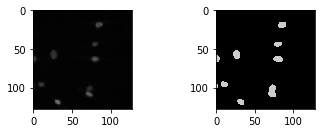

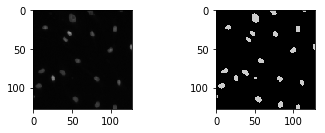

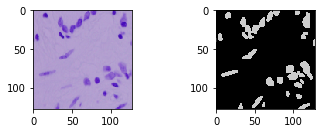

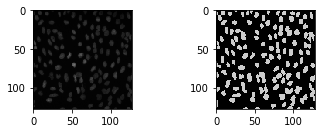

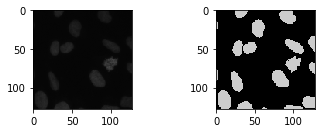

In [15]:
for id in sample_images_ids:
    plt.subplot(221)
    plt.imshow(X_train[id])
    plt.subplot(222)
    plt.imshow(np.squeeze(Y_train[id]))
    plt.show()

# Define the model

We will use the U-Net model, loosely based on U-Net: [Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf) and very similar to this [repo](https://github.com/jocicmarko/ultrasound-nerve-segmentation) from the Kaggle Ultrasound Nerve Segmentation competition.

In [32]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

Using TensorFlow backend.


In [46]:
def get_unet():
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=None)

    return model


In [47]:
model = get_unet()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 128, 128, 32) 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_97 (Conv2D)              (None, 128, 128, 32) 9248        conv2d_96[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_21 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_97[0][0]                  
__________________________________________________________________________________________________
conv2d_98 